In [1]:
import pandas as pd
from networkx import *
import numpy as np
import networkx as nx
from itertools import combinations
import time
import pickle, matplotlib


In [2]:
## import data
# data = pd.read_csv(root)
df = pd.read_csv("../OneDrive_1_9-3-2021/Reddit.csv", header = 0)
df.shape
# mean of weights

(286561, 3)

In [3]:
name = df.columns[2]
from_name = df.columns[0]
to_name = df.columns[1]
# df = df.replace({'Morality': {'Virtue': 1, 'Vice': -1, 'Neutral': 0}})
# df = df.drop(df[df.Morality == 0].index)

In [4]:
# averaging without consider direction of from to (used for undirected graph)
df['nodes'] = df[[from_name, to_name]].values.tolist()
df['nodes'] = df['nodes'].apply(lambda x: '--'.join(sorted(map(str, x))))
df = df[['nodes', from_name, to_name, name]].groupby(['nodes'])[name].mean().reset_index()
df[[from_name, to_name]] = df.nodes.apply(
   lambda x: pd.Series(str(x).split("--")))
df.shape

(124330, 4)

In [5]:
df[name] = df[name].replace(to_replace = [i for i in set(df[name]) if i>0], value =1)
df[name] = df[name].replace(to_replace = [i for i in set(df[name]) if i<0], value =-1)
df = df.drop(df[df[name] == 0].index)
df.shape
# df.loc[(df['Sign'] > 0)]


# df = df.replace({'Morality': {'Virtue': 1, 'Vice': -1, 'Neutral': 0}})
# df = df.drop(df[df.Morality == 0].index)

# above 0 -> 1 below 0 -> -1
# df = df.drop(df[df.Average_sentiment_score == 0].index)
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values(by=['Date'], ascending=True)

(122347, 4)

In [6]:
G_all=nx.from_pandas_edgelist(df,source=from_name, target=to_name, edge_attr=name, create_using=nx.Graph())

In [11]:
c = 0
while(1):
    G_all.remove_nodes_from(list(nx.isolates(G_all)))
    remove = [node for node,degree in G_all.degree() if degree == 1]
    G_all.remove_nodes_from(remove)
    G_all.remove_edges_from(nx.selfloop_edges(G_all, data=True))
    if c == number_of_edges(G_all):
        break
    else:
        c = number_of_edges(G_all)

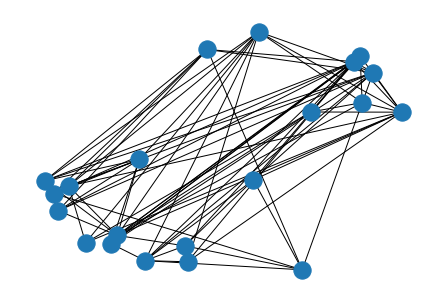

In [26]:
nx.draw(G_all)

In [ ]:
from itertools import combinations

info = []
for nodes in combinations(G_all.nodes, 3):
    n_edges = G_all.subgraph(nodes).number_of_edges()
    if n_edges == 3:
        ratio = 1 if np.product([w[name] for n1, n2, w in G_all.subgraph(nodes).edges.data()]) == 1 else 0
        info.append([G_all.subgraph(nodes).edges.data(), 'X', nodes, ratio])
info = pd.DataFrame(info)
info.to_csv('../info_triads/Reddit_undirected.csv', index=False)

In [28]:
from collections import Counter
Counter(info[3])

Counter({1: 58, 0: 23})

### number of negative edge in triangles

In [ ]:
import pandas as pd
import ast
file = pd.read_csv('../info_triads/Reddit_undirected.csv', header=0)
file['0'] = file['0'].apply(ast.literal_eval)

In [ ]:
counter = dict()
for triangle in file['0'].tolist():
    counter.setdefault([edge[2]['Sign'] for edge in triangle].count(-1), 0)
    counter[[edge[2]['Sign'] for edge in triangle].count(-1)] += 1
counter

## Directed Graph

In [12]:

df = pd.read_csv("../OneDrive_1_9-3-2021/Reddit.csv", header = 0)
name = df.columns[2]
from_name = df.columns[0]
to_name = df.columns[1]

# averaging by from to (used for directed graph)
df = df[[from_name, to_name, name]].groupby([from_name, to_name]).mean().reset_index()

df[name] = df[name].replace(to_replace = [i for i in set(df[name]) if i>0], value =1)
df[name] = df[name].replace(to_replace = [i for i in set(df[name]) if i<0], value =-1)
df = df.drop(df[df[name] == 0].index)
df.shape

(83, 3)

In [13]:
from itertools import combinations

## Get all triples in triads with respect to their census and edgelists (in edge_atts)
def get_directed_triads(undirected_triad):
    # Get all triplets of edges
    list_tri = []
    for candidate_edges in combinations(undirected_triad.edges.data(), 3):
        # Get edges between unique pair of nodes
        unique_edges = set([tuple(sorted((s,e))) for s,e,w in candidate_edges])
        start_nodes = set([s for s,e,w in candidate_edges])
        # Only consider triad in which the tree edges use a unique pair of nodes
        if len(unique_edges) == 3 and len(start_nodes) !=3:
            yield candidate_edges

In [14]:
G_all=nx.from_pandas_edgelist(df,source=from_name, target=to_name, edge_attr=name, create_using=nx.DiGraph())


In [15]:
c = 0
while(1):
    G_all.remove_nodes_from(list(nx.isolates(G_all)))
    remove = [node for node,degree in G_all.degree() if degree == 1]
    G_all.remove_nodes_from(remove)
    G_all.remove_edges_from(nx.selfloop_edges(G_all, data=True))
    if c == number_of_edges(G_all):
        break
    else:
        c = number_of_edges(G_all)

In [17]:
# G_all=nx.from_pandas_edgelist(df,source=from_name, target=to_name, edge_attr=name, create_using=nx.DiGraph())
useless_census = ['003','012', '102', '021D', '021C', '021U', '021', '111U', '111D', '201', '030C', '120C', '210']
info = []
for triads in all_triads(G_all):
    if triad_type(triads) not in useless_census:
        all_values = {1:0, 0:0, -1:0}
        for triangle in get_directed_triads(triads):
#             print(triangle)
            all_values[np.product([w[name] for n1, n2, w in triangle])] += 1
#         ratio = 0
#         if all_values[0] == 0:
        ratio = all_values[1]/(all_values[1]+all_values[-1])
#         print([triads.edges.data(), triad_type(triads), set([k[0] for k in triads.edges.data()]+[k[1] for k in triads.edges.data()]), ratio])
#         print('---------')
        info.append([triads.edges.data(), triad_type(triads), set([k[0] for k in triads.edges.data()]+[k[1] for k in triads.edges.data()]), ratio])
info = pd.DataFrame(info)
info.to_csv('../info_triads/Reddit_directed.csv', index=False)

In [18]:
from collections import Counter
Counter(info[3])

Counter({0.0: 17, 1.0: 24, 0.5: 5})

### number of negative edge in triangles

In [ ]:
import pandas as pd
import networkx as nx
from networkx import *

df = pd.read_csv("../OneDrive_1_9-3-2021/Reddit.csv", header = 0)
name = df.columns[2]
from_name = df.columns[0]
to_name = df.columns[1]

# averaging by from to (used for directed graph)
df = df[[from_name, to_name, name]].groupby([from_name, to_name]).mean().reset_index()

df[name] = df[name].replace(to_replace = [i for i in set(df[name]) if i>0], value =1)
df[name] = df[name].replace(to_replace = [i for i in set(df[name]) if i<0], value =-1)
df = df.drop(df[df[name] == 0].index)
df.shape

In [ ]:
from itertools import combinations

## Get all triples in triads with respect to their census and edgelists (in edge_atts)
def get_directed_triads(undirected_triad):
    # Get all triplets of edges
    list_tri = []
    for candidate_edges in combinations(undirected_triad.edges.data(), 3):
        # Get edges between unique pair of nodes
        unique_edges = set([tuple(sorted((s,e))) for s,e,w in candidate_edges])
        start_nodes = set([s for s,e,w in candidate_edges])
        # Only consider triad in which the tree edges use a unique pair of nodes
        if len(unique_edges) == 3 and len(start_nodes) !=3:
            yield candidate_edges

In [ ]:
G_all=nx.from_pandas_edgelist(df,source=from_name, target=to_name, edge_attr=name, create_using=nx.DiGraph())
c = 0
while(1):
    G_all.remove_nodes_from(list(nx.isolates(G_all)))
    remove = [node for node,degree in G_all.degree() if degree == 1]
    G_all.remove_nodes_from(remove)
    G_all.remove_edges_from(nx.selfloop_edges(G_all, data=True))
    if c == number_of_edges(G_all):
        break
    else:
        c = number_of_edges(G_all)

In [ ]:
useless_census = ['003','012', '102', '021D', '021C', '021U', '021', '111U', '111D', '201', '030C', '120C', '210']

## getting the balance vs. imbalance triads 
balances = []
unbalances = []
for items in all_triads(G_all):
    if triad_type(items) not in useless_census:
        balance_list = []
        if triad_type(items) == '300':
            for triangle in get_directed_triads(items):
                node = []
                for edge in triangle:
                    if edge[0] not in node:
                        node.append(edge[0])
                if len(node) != 3:
                    balance = 1
                    for edge in triangle:
                        balance *= edge[2][name]
                    balance_list.append(balance)
        else:
            for item in get_directed_triads(items):
                balance = 1
                for edge in item:
                    balance *= edge[2][name]
                balance_list.append(balance)
        if -1 in balance_list:
            unbalances.append(items)
        else:
            balances.append(items)


In [ ]:
## number of balanced traids
dict_balance = dict()
for i in balances:
    for triangle in get_directed_triads(i):
        if [e[2][name] for e in triangle].count(-1) not in dict_balance.keys():
            dict_balance[[e[2][name] for e in triangle].count(-1)]=0
        dict_balance[[e[2][name] for e in triangle].count(-1)]+=1
print(dict_balance)

In [ ]:
## number of imbalance triads
dict_unbalance = {}
for i in unbalances:
    for triangle in get_directed_triads(i):
        if [e[2][name] for e in triangle].count(-1) not in dict_unbalance.keys():
            dict_unbalance[[e[2][name] for e in triangle].count(-1)]=0
        dict_unbalance[[e[2][name] for e in triangle].count(-1)]+=1
print(dict_unbalance)

## Others

In [84]:
# G_all=nx.from_pandas_edgelist(df,source=from_name, target=to_name, edge_attr=name, create_using=nx.Graph())
# all_cliques= nx.enumerate_all_cliques(G_all)
triad_cliques=[c for c in nx.cycle_basis(G_all) if len(c)==3]
info = []
for t in triad_cliques:
    tri=nx.subgraph(G_all,t)
    ratio = 1 if np.product([w[name] for n1, n2, w in tri.edges.data()]) == 1 else 0
    info.append([tri.edges.data(), 'X', t, ratio])
info = pd.DataFrame(info)
info.to_csv('info_triads/Highland Tribes_sym_undirected.csv', index=False)

Calculating Balance

In [11]:
## adding the edge attribute (signs) to the network
sign = nx.get_edge_attributes(G_all,name)

Transitive Triads

In [131]:
# # transitive triads
# start_time = time.clock()
# triad_class = {}
# useless_census = ['003','012', '102', '021D', '021C', '021U', '021', '111U', '111D', '201', '030C', '120C', '210']
# for nodes in combinations(G_all.nodes, 3):
#     census = [k for k, v in nx.triads.triadic_census(G_all.subgraph(nodes)).items() if v][0]
#     if census not in useless_census:
#         morality = nx.get_edge_attributes(G_all.subgraph(nodes),'Morality')
#         triad_class[nodes] = [census, morality]
# print (time.clock() - start_time, "seconds")

In [132]:
## creating the semi-cycles within the triad census
# from itertools import combinations

# ## Get all triples in triads with respect to their census and edgelists (in edge_atts)
# def get_directed_triads(undirected_triad):
#     # Get all triplets of edges
#     for candidate_edges in combinations(undirected_triad.items(), 3):
#         # Get edges between unique pair of nodes
#         unique_edges = set([tuple(sorted(k)) for k,v in candidate_edges])
#         # Only consider triad in which the tree edges use a unique pair of nodes
#         if len(unique_edges) == 3:
#             yield dict(candidate_edges)

In [133]:
# all_triads = []
# for key, value in triad_class.items():
#     #for directed_triad in get_directed_triads(value[1]):
#     all_directed_triads = list(get_directed_triads(value[1]))
#     all_triads.append([all_directed_triads, value[0]])
#     #print (all_directed_triads)

In [10]:
import numpy as np
## extract all the triads
triangles = [c for c in nx.cycle_basis(G_all) if len(c)==3]
triangle_types={}
for triangle in triangles:
    tri=nx.subgraph(G_all,triangle)
    #take the product of the edge relationships. If there are an odd number of -1s, the triangle is unbalanced.
    triangle_types[tuple(tri.nodes())]=np.product([x[2][name] for x in tri.edges(data=True)])
# print(triangle_types)

In [11]:
## how many balanced and imbalanced triads do we have in this graph?
from collections import Counter
Counter(triangle_types.values())

Counter({1: 23, -1: 6})

In [12]:
## what is the ovreall balance score of the graph? (# of balanced triads/number of all triads )
balance_score = Counter(triangle_types.values())[1]/len(triangle_types)
balance_score

0.7931034482758621

In [137]:
## what is the ovreall imbalance score of the graph? (# of balanced triads/number of all triads )
imbalance_score = Counter(triangle_types.values())[-1]/len(triangle_types)
imbalance_score

0.3274974253347065

### len(triad_class)

In [75]:
# ## getting the balance vs. imbalance triads 
# balances = []
# unbalances = []
# for items in all_triads:
#     balance_list = []
#     if items[1] == '300':
#         for triangle in items[0]:
#             node = []
#             for edge in triangle:
#                 if edge[0] not in node:
#                     node.append(edge[0])
#             if len(node) != 3:
#                 balance = 1
#                 for edge in triangle:
#                     balance *= triangle[edge]
#                 balance_list.append(balance)
#     else:
#         for item in items[0]:
#             balance = 1
#             for edge in item:
#                 balance *= item[edge]
#             balance_list.append(balance)
#     if -1 in balance_list:
#         unbalances.append(items)
#     else:
#         balances.append(items)


In [76]:
# ## number of balanced traids
# dict_balance = {}
# for i in balances:
#     if i[1] not in dict_balance:
#         dict_balance[i[1]] = 1
#     else:
#         dict_balance[i[1]] += 1
# print(dict_balance)

In [77]:
# ## number of imbalance triads
# dict_unbalance = {}
# for i in unbalances:
#     if i[1] not in dict_unbalance:
#         dict_unbalance[i[1]] = 1
#     else:
#         dict_unbalance[i[1]] += 1
# print(dict_unbalance)

In [68]:
## TODO: get the % of balance vs. imbalance of transitive triads